## De-drifting

### Read the data

In [94]:
control_files = '/g/data1/r87/drstree/CMIP5/GCM/CSIRO-QCCCE/CSIRO-Mk3-6-0/piControl/mon/ocean/thetao/r1i1p1/thetao_Omon_CSIRO-Mk3-6-0_piControl_r1i1p1_*.nc'

In [95]:
import xarray

In [96]:
ds = xarray.open_mfdataset(control_files, decode_cf=False)

The `decode_cf` option turns off the automatic conversion of the time axis to `numpy.datetime64` objects, which fails for the control runs because their time values don't make sense:
```
/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/xarray/conventions.py:382: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)

```

In [97]:
print ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 189, lev: 31, lon: 192, time: 6000)
Coordinates:
  * lev        (lev) float64 5.0 15.0 28.25 42.02 59.66 78.54 102.1 127.9 ...
  * lat        (lat) float64 -88.2 -87.24 -86.3 -85.36 -84.42 -83.49 -82.55 ...
  * lon        (lon) float64 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.12 15.0 ...
  * bnds       (bnds) int64 0 1
  * time       (time) float64 15.5 45.0 74.5 105.0 135.5 166.0 196.5 227.5 ...
Data variables:
    time_bnds  (time, bnds) float64 0.0 31.0 31.0 59.0 59.0 90.0 90.0 120.0 ...
    lat_bnds   (time, lat, bnds) float64 -90.0 -87.71 -87.71 -86.77 -86.77 ...
    lon_bnds   (time, lon, bnds) float64 -0.9375 0.9375 0.9375 2.812 2.812 ...
    lev_bnds   (time, lev, bnds) float64 0.0 10.0 10.0 21.62 21.62 35.14 ...
    thetao     (time, lev, lat, lon) float32 1e+20 1e+20 1e+20 1e+20 1e+20 ...
Attributes:
    institution: Australian Commonwealth Scientific and Industrial Research Organization (CSIRO) Marine and Atmospheric Research (Me

In [98]:
print ds.time.values[0]
print ds.time.values[-1]

15.5
182484.5


In [99]:
ds.nbytes * (2 ** -30)

25.181073054671288

So there is 25.2 GB of data, according to the conversion that Stephan Hoyer does at [this blog post](https://www.continuum.io/content/xray-dask-out-core-labeled-arrays-python). Interestingly, if the time axis is converted to `numpy.datetime64` objects then the size blows out to 50.3 GB.

In [100]:
ds.chunks

Frozen(SortedKeysDict({u'lat': (189,), u'bnds': (2,), u'lon': (192,), u'lev': (31,), u'time': (120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120)}))

According to [this post](http://stackoverflow.com/questions/23849097/numpy-np-apply-along-axis-function-speed-up), `numpy.apply_along_axis()` is not for speed. It gives some other more difficult options for speeding things up, but I'm thinking dask map_blocks will work if I can rechuck such that there is a chunk for every grid point...

In [ ]:
rechunked = ds.chunk({'time':6000, 'lev':1, 'lat':1, 'lon':1})
print rechunked.chunks

### Figure out how the coefficient calculation works

#### Fake data

In [21]:
import numpy
import matplotlib.pyplot as plt

In [22]:
% matplotlib inline

In [23]:
x = [2.53240, 1.91110, 1.18430, 0.95784, 0.33158,
     -0.19506, -0.82144, -1.64770, -1.87450, -2.2010]

y = [-2.50400, -1.62600, -1.17600, -0.87400, -0.64900,
     -0.477000, -0.33400, -0.20600, -0.10100, -0.00600]

coefficients = numpy.polyfit(x, y, 3)

print coefficients

[-0.03663771 -0.09944278 -0.28178298 -0.53596979]


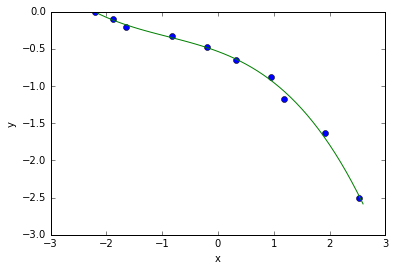

In [24]:
polynomial = numpy.poly1d(coefficients)
xs = numpy.arange(-2.2, 2.6, 0.1)
ys = polynomial(xs)

plt.plot(x, y, 'o')
plt.plot(xs, ys)
plt.ylabel('y')
plt.xlabel('x')
plt.show()

#### Single grid point

In [82]:
darray = ds['thetao']
subset_dict = dict(lon=150, lat=-50, lev=15.0, method='nearest')
grid_point_data = darray.sel(**subset_dict)

In [83]:
print grid_point_data.shape
print type(grid_point_data)

(6000,)
<class 'xarray.core.dataarray.DataArray'>


In [84]:
print grid_point_data.time.values

[  1.55000000e+01   4.50000000e+01   7.45000000e+01 ...,   1.82423500e+05
   1.82454000e+05   1.82484500e+05]


In [87]:
x = grid_point_data.time.values
y = grid_point_data.values
 
a, b, c, d = numpy.polyfit(x, y, 3)
#a, b, c, d = numpy.polynomial.polynomial.polyfit(x, y, 3)

In [86]:
print a, b, c, d

281.36891698 2.89929102902e-06 -1.94524448455e-11 3.03710384894e-17


For the expression $ax^3 + bx^2 + cx + d$, `numpy.polyfit` returns a, b, c, d, while `numpy.polynomial.polynomial.polyfit` returns d, c, b, a. I read that the polynomial one is more recent, but it doesn't seem to be any faster.

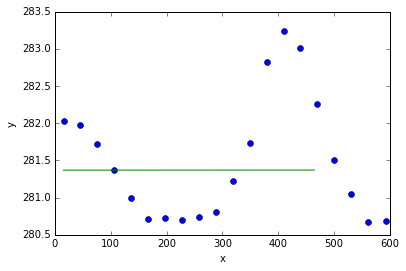

In [56]:
polynomial = numpy.poly1d([a, b, c, d])
#xs = numpy.arange(ds.time.values[0], ds.time.values[-1], 50)
xs = numpy.arange(15, 500, 50)
ys = polynomial(xs)

plt.plot(x[0:20], y[0:20], 'o')
plt.plot(xs, ys)
plt.ylabel('y')
plt.xlabel('x')
plt.show()

#### Multiple grid points

In [77]:
def my_polyfit(data):
    
    return numpy.polyfit(data, my_time_axis, 3)

In [88]:
subset_dict = dict(lon=150, lat=slice(-50, -48), lev=15.0)
multi_point_data = darray.sel(**subset_dict)

In [89]:
print multi_point_data

<xarray.DataArray 'thetao' (time: 6000, lat: 3)>
dask.array<getitem..., shape=(6000, 3), dtype=float32, chunksize=(120, 3)>
Coordinates:
    lev      float64 15.0
  * lat      (lat) float64 -49.9 -48.97 -48.03
    lon      float64 150.0
  * time     (time) float64 15.5 45.0 74.5 105.0 135.5 166.0 196.5 227.5 ...
Attributes:
    standard_name: sea_water_potential_temperature
    long_name: Sea Water Potential Temperature
    units: K
    original_name: Temp
    comment: Data is stored on the native ocean T-grid on which the data was generated. (MOM2 uses a rectangular staggered grid with T cells and U cells.)
    original_units: celsius
    cell_methods: time: mean
    cell_measures: area: areacello volume: volcello
    missing_value: 1e+20
    _FillValue: 1e+20
    associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_CSIRO-Mk3-6-0_piControl_r0i0p0.nc areacello: areacello_fx_CSIRO-Mk3-6-0_piControl_r0i0p0.nc volcello: volcello_fx_CSIRO

In [ ]:
rechunked = ds.chunk({'time': 1956, 'lev': 1})

In [80]:
my_time_axis = multi_point_data.time.values
y = multi_point_data.values
#x = x[..., numpy.newaxis]

hello = numpy.apply_along_axis(my_polyfit, 0, x)

In [81]:
print hello.shape

(4, 1)


In [69]:
x[..., numpy.newaxis].shape

(6000, 1)